<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Two-dimensional-non-convex-problem" data-toc-modified-id="Two-dimensional-non-convex-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Two dimensional non-convex problem</a></span><ul class="toc-item"><li><span><a href="#Gradient-algorithm" data-toc-modified-id="Gradient-algorithm-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Gradient algorithm</a></span><ul class="toc-item"><li><span><a href="#Fixed-step-size-gradient-algorithm" data-toc-modified-id="Fixed-step-size-gradient-algorithm-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Fixed step size gradient algorithm</a></span></li><li><span><a href="#Receeding-step-size" data-toc-modified-id="Receeding-step-size-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Receeding step size</a></span></li></ul></li><li><span><a href="#Conjugate-gradient" data-toc-modified-id="Conjugate-gradient-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Conjugate gradient</a></span></li><li><span><a href="#Newton's-method" data-toc-modified-id="Newton's-method-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Newton's method</a></span></li><li><span><a href="#Quasi-Newton-Method" data-toc-modified-id="Quasi-Newton-Method-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Quasi-Newton Method</a></span></li><li><span><a href="#Plotting-multiple-trajectories" data-toc-modified-id="Plotting-multiple-trajectories-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plotting multiple trajectories</a></span></li></ul></li><li><span><a href="#Quadratic-function-and-conditionning" data-toc-modified-id="Quadratic-function-and-conditionning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quadratic function and conditionning</a></span></li><li><span><a href="#Non-convex-function-in-higher-dimension" data-toc-modified-id="Non-convex-function-in-higher-dimension-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Non-convex function in higher dimension</a></span></li></ul></div>

# Testing multiple optimization method

We start by adding some libraries.

In [2]:
# uncomment and run once to install
using Pkg
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Optim")


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [3]:
Pkg.add("PlotlyJS")
Pkg.add("ORCA")# if you want to try plotlyjs()

  Resolving package versions...
  Installed JSExpr ────── v0.5.2
  Installed Mux ───────── v0.7.5
  Installed BinDeps ───── v1.0.2
  Installed PlotlyBase ── v0.5.2
  Installed PlotlyJS ──── v0.14.1
  Installed Kaleido_jll ─ v0.1.0+0
  Installed Mustache ──── v1.0.10
  Installed Blink ─────── v0.12.5
Updating `~/.julia/environments/v1.5/Project.toml`
  [f0f68f2c] + PlotlyJS v0.14.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [9e28174c] + BinDeps v1.0.2
  [ad839575] + Blink v0.12.5
  [97c1335a] + JSExpr v0.5.2
  [f7e6163d] + Kaleido_jll v0.1.0+0
  [ffc61752] + Mustache v1.0.10
  [a975b10e] + Mux v0.7.5
  [a03496cd] + PlotlyBase v0.5.2
  [f0f68f2c] + PlotlyJS v0.14.1
   Building Blink ───→ `~/.julia/packages/Blink/mwJC9/deps/build.log`
   Building PlotlyJS → `~/.julia/packages/PlotlyJS/h3GxO/deps/build.log`
  Resolving package versions...
  Installed ORCA ───────────── v0.5.0
  Installed Conda ──────────── v1.5.2
  Installed PlotlyBase ─────── v0.4.3
  Installed JuliaInterpreter

In [1]:
# run to make the library available
using Plots, LinearAlgebra, Optim 
#plotlyjs() #Plots has multiple plotting backend. plotlyjs() has more interactivity in notebook but sometimes buggy
pyplot()

Plots.PyPlotBackend()

## Two dimensional non-convex problem

We define the Rosenbrock (a.k.a banana) function $f(x,y) = (1-x)^2 + 5(y-x^2)^2$. 

It is a function well known to be difficult to optimize.

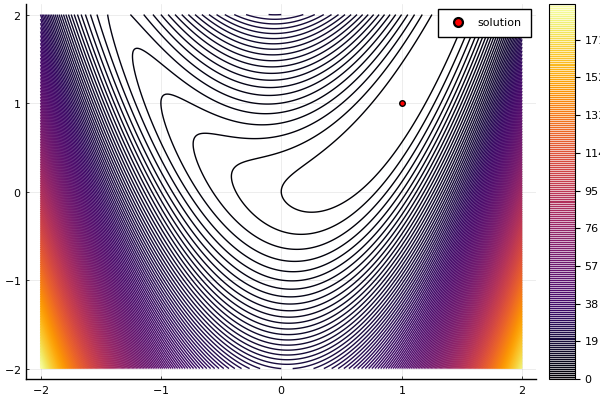

In [198]:
# Run to define the objective function, its gradient hessian, and plot its level set
# might take some time to run
f = x -> (1-x[1])^2 + 5*(x[2] - x[1]^2)^2
df = x -> [2*(10*x[1]^3-10*x[1]*x[2]+x[1]-1), 10*(x[2]-x[1]^2)]
hf = x -> [60x[1]^2-20x[2]+2 -20x[1]; -20x[1] 10]

#
x0 = Float64[-0.5, 2] #Initial point
ε = 1e-6              #tolerance for the stopping test, here the gradient
IT_MAX = 5000         #max number of iterations, always a good idea to have this as fail-safe

xdomain = -2:0.01:2
ydomain = -2:0.01:2

lev_line = contour(xdomain,ydomain,(x,y)->f([x,y]), levels = 200);
lev_line = plot!(lev_line,[1],[1],seriestype = :scatter, color = :red,label="solution");
lev_line

The following function plot the trajectory of an algorithm on this example.

In [199]:
# The last argument is used to plot on top of an already computed plot. 
# By default it is the contour level set
function plot_trajectory(pts;color="blue",label=`AUTO`,shape=:cross,plt=lev_line)
    plt = deepcopy(plt)
    plot!(plt,[p[1] for p in pts],[p[2] for p in pts],color=color,label=label,shape=shape)
    return plt
end


plot_trajectory (generic function with 1 method)

The following function plots graph showing the convergence of the algorithm

In [200]:
function plot_convergence(vals,grads,steps)
    p1 = plot(vals, title = "Objective value")
    p2 = plot(log10.(vals .- vals[end]),title = "log gap value")
    p3 = plot(log10.(norm.(grads)), title = "log gradient norm") 
    p4 = plot(steps, title = "Step-size")
    plot(p1, p2, p3,p4, layout = (2, 2), legend = false)
end

plot_convergence (generic function with 1 method)

### Gradient algorithm

We start with the most classical descent direction algorithm.

#### Fixed step size gradient algorithm

gradient algorithm with fixed step t=0.05 ended in 5000 iterations and 5000 oracle call


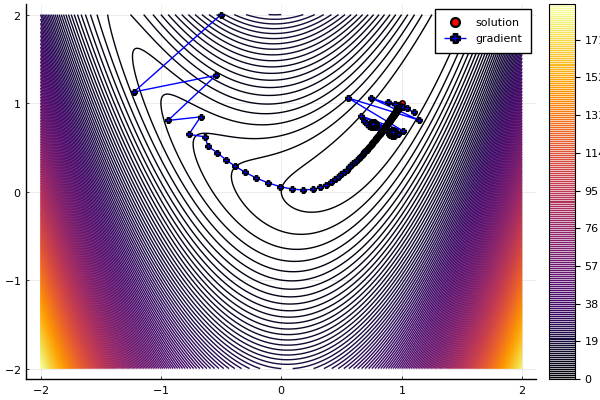

In [149]:
t0 = 0.02             #default step size



function gradient_fixed_step(x0,f,df;t0=t0)
    x = x0
    
    pts = [x]
    vals = [f(x)]
    grads = [df(x)]
    steps = [t0]

    stop_test = false
    it = 0 #iteration number

    while !stop_test
        # update
        g = df(x)
        ### TO COMPLETE
        d = -g           # descent direction
        t = t0             # step size
        x += t*d           # update

        # keeping track of results
        push!(pts,x)
        push!(vals,f(x))
        push!(grads,g)
        push!(steps,t0)
        
        # stopping test
        it += 1
        stop_test = (it > IT_MAX - 1) || (norm(g)<ε)
    end
    
    println("gradient algorithm with fixed step t=",t0, " ended in ", it, " iterations and ", it," oracle call")
    return pts, vals, grads, steps
   
end

pts_gf, vals, grads, steps = gradient_fixed_step(x0,f,df,t0=0.05);
plt = plot_trajectory(pts_gf,label="gradient") # plotting the trajectory

In [150]:
plot_convergence(vals,grads,steps)

LoadError: DomainError with -0.011268159261921457:
NaN result for non-NaN input.


<div class="alert alert-success"> <b>Question 1)</b> 
    
Numerically check that the algorithm does not converge for large step-size. Plot the corresponding trajectory.

Find the best fixed step-size. What do you observe ?
</div>


NB: I got 845 iterations.

Q1:We observe for a large step-size of $t_0=0.05$ that the algorithm fails to approach the optimal point and reaches the maximum number of iterations. Indeed, at first it does approach the optimal point, but then turns around this point indefinitely. This is because of the step-size which is too wide for the end of the optimization. 

The optimal step-size is given by $t_0=0.039$ and we get $845$ iterations (we can do better by a few iterations with more precision, eg t0=0.03925). We observe that the algorithm approaches the solution at regular step, which doesn't seem optimal as we could accelerate the optimization at the begining. Yet, we can't choose a wider step-size as it would fail in the very end of the optimization to approach the solution: this is the problem of an algorithm with fixed step-size such as this one.

#### Receeding step size

We are now going to use a receeding step size.



<div class="alert alert-success"> <b>Question 2)</b> 
    
Complete the receeding_step code.

Play with the parameters of the gradient with receeding step to get the smallest number of oracle calls.
</div>
NB : I got 267 calls.

The smallest number of oracle calls is reached for a reducing factor of , and a slop_coefficient of .

In [151]:
function receeding_step(f,g,x,d;reducing_factor=.5,slope_coefficient=0.5,it_max = 10, verbose = true, t0=1)
    f0 = f(x)
    t = t0
    it = 1
    t_traj = [t]
    
    while ( f(x+t*d) > f0+slope_coefficient*t*transpose(g)*d ) && (it <= it_max)
        t = reducing_factor*t
        push!(t_traj,t)
        it += 1
    end
    
    if verbose
        f(x+t*d) >= f0 && println("non reducing step ", "it = ", it)
        it==it_max + 1 && println("maximum number of receeding iterations attained") 
    end
    return t_traj
end

receeding_step (generic function with 1 method)

In [152]:
function gradient_receeding_step(x0,f,df;
        t0=t0, reducing_factor=.9,slope_coefficient=0.5,it_max = 10, verbose = false)
    x = x0
    
    pts = [x]
    pts_full = [x]
    vals = [f(x)]
    grads = [df(x)]
    steps = []

    stop_test = false
    it = 0 #iteration number
    calls = 0

    while !stop_test
         
        g = df(x)
        d = - g       # descent direction
        t_traj = receeding_step(f,g,x,d;
            reducing_factor=reducing_factor,slope_coefficient=slope_coefficient,
            it_max = it_max, verbose = verbose, t0=t0)# step size
        calls += length(t_traj)
        t = t_traj[end]
        for t in t_traj
            push!(pts_full, x+t*d)
        end
        x += t*d          # step

        # keeping track of results
        push!(pts,x)
        push!(vals,f(x))
        push!(grads,g)
        push!(steps,t)
        
        
        
        # stopping test
        it += 1
        stop_test = (it > IT_MAX - 1) || (norm(g)<ε)
    end
    
    println("gradient algorithm with receeding step size ended in ", it, " iterations and ", calls," oracle calls")

    return pts, pts_full, vals, grads, steps

end

pts_gr, pts_gr_full, vals, grads, steps = gradient_receeding_step(x0,f,df;t0=0.5, reducing_factor=.2,slope_coefficient=0.5,it_max = 10, verbose = false);

gradient algorithm with receeding step size ended in 138 iterations and 287 oracle calls


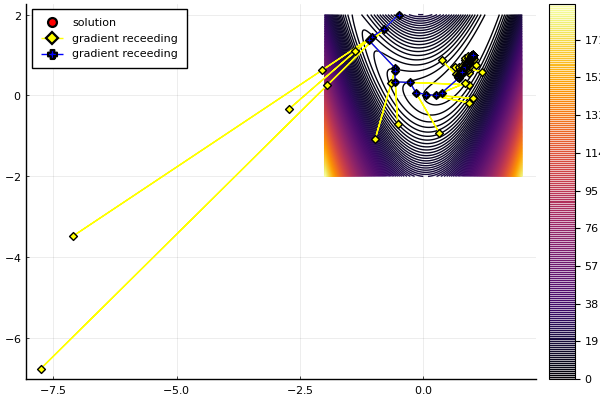

In [153]:
plt = plot_trajectory(pts_gr_full,label="gradient receeding",shape = :diamond,color = :yellow)
plt = plot_trajectory(pts_gr,label="gradient receeding",plt=plt)


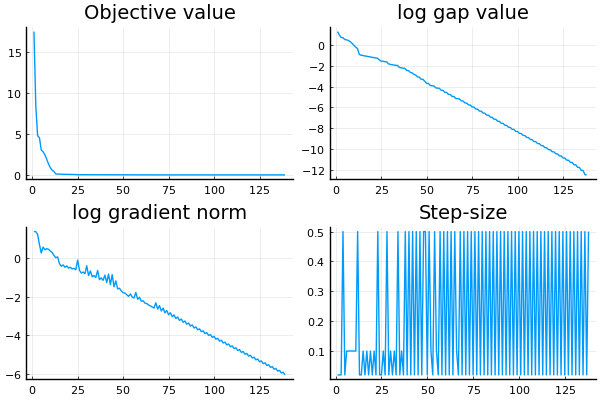

In [154]:
plot_convergence(vals,grads,steps)

In [155]:
for t in range(0.1, 1.0, length = 10)
    for alpha in range(0.1, 0.5, length = 5)
        for beta in range(0.1, 1.0, length = 10)
            println(t,alpha,beta)
            gradient_receeding_step(x0,f,df;t0=t, reducing_factor=beta,slope_coefficient=alpha,it_max = 10, verbose = false)
        end
    end
end

0.10.10.1
gradient algorithm with receeding step size ended in 829 iterations and 1381 oracle calls
0.10.10.2
gradient algorithm with receeding step size ended in 432 iterations and 561 oracle calls
0.10.10.3
gradient algorithm with receeding step size ended in 627 iterations and 1047 oracle calls
0.10.10.4
gradient algorithm with receeding step size ended in 693 iterations and 1353 oracle calls
0.10.10.5
gradient algorithm with receeding step size ended in 615 iterations and 1298 oracle calls
0.10.10.6
gradient algorithm with receeding step size ended in 801 iterations and 2210 oracle calls
0.10.10.7
gradient algorithm with receeding step size ended in 819 iterations and 2887 oracle calls
0.10.10.8
gradient algorithm with receeding step size ended in 907 iterations and 4906 oracle calls
0.10.10.9
gradient algorithm with receeding step size ended in 852 iterations and 8463 oracle calls
0.10.11.0
gradient algorithm with receeding step size ended in 5000 iterations and 5060 oracle calls


gradient algorithm with receeding step size ended in 577 iterations and 2245 oracle calls
0.20.40.7
gradient algorithm with receeding step size ended in 726 iterations and 3910 oracle calls
0.20.40.8
gradient algorithm with receeding step size ended in 788 iterations and 6397 oracle calls
0.20.40.9
gradient algorithm with receeding step size ended in 5000 iterations and 5080 oracle calls
0.20.41.0
gradient algorithm with receeding step size ended in 5000 iterations and 5060 oracle calls
0.20.50.1
gradient algorithm with receeding step size ended in 264 iterations and 378 oracle calls
0.20.50.2
gradient algorithm with receeding step size ended in 845 iterations and 1780 oracle calls
0.20.50.3
gradient algorithm with receeding step size ended in 333 iterations and 673 oracle calls
0.20.50.4
gradient algorithm with receeding step size ended in 686 iterations and 1953 oracle calls
0.20.50.5
gradient algorithm with receeding step size ended in 427 iterations and 1366 oracle calls
0.20.50.6


gradient algorithm with receeding step size ended in 5000 iterations and 54958 oracle calls
0.40.30.9
gradient algorithm with receeding step size ended in 5000 iterations and 5060 oracle calls
0.40.31.0
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
0.40.40.1
gradient algorithm with receeding step size ended in 958 iterations and 2133 oracle calls
0.40.40.2
gradient algorithm with receeding step size ended in 295 iterations and 695 oracle calls
0.40.40.3
gradient algorithm with receeding step size ended in 681 iterations and 2042 oracle calls
0.40.40.4
gradient algorithm with receeding step size ended in 457 iterations and 1504 oracle calls
0.40.40.5
gradient algorithm with receeding step size ended in 456 iterations and 1839 oracle calls
0.40.40.6
gradient algorithm with receeding step size ended in 249 iterations and 1158 oracle calls
0.40.40.7
gradient algorithm with receeding step size ended in 544 iterations and 3831 oracle calls
0.40.40

gradient algorithm with receeding step size ended in 5000 iterations and 5060 oracle calls
0.60.31.0
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
0.60.40.1
gradient algorithm with receeding step size ended in 1270 iterations and 3401 oracle calls
0.60.40.2
gradient algorithm with receeding step size ended in 246 iterations and 611 oracle calls
0.60.40.3
gradient algorithm with receeding step size ended in 319 iterations and 993 oracle calls
0.60.40.4
gradient algorithm with receeding step size ended in 696 iterations and 2754 oracle calls
0.60.40.5
gradient algorithm with receeding step size ended in 156 iterations and 619 oracle calls
0.60.40.6
gradient algorithm with receeding step size ended in 631 iterations and 3872 oracle calls
0.60.40.7
gradient algorithm with receeding step size ended in 678 iterations and 5707 oracle calls
0.60.40.8
gradient algorithm with receeding step size ended in 5000 iterations and 5100 oracle calls
0.60.40.9

gradient algorithm with receeding step size ended in 749 iterations and 5134 oracle calls
0.80.20.7
gradient algorithm with receeding step size ended in 885 iterations and 8477 oracle calls
0.80.20.8
gradient algorithm with receeding step size ended in 5000 iterations and 5070 oracle calls
0.80.20.9
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
0.80.21.0
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
0.80.30.1
gradient algorithm with receeding step size ended in 1048 iterations and 2821 oracle calls
0.80.30.2
gradient algorithm with receeding step size ended in 588 iterations and 1735 oracle calls
0.80.30.3
gradient algorithm with receeding step size ended in 172 iterations and 527 oracle calls
0.80.30.4
gradient algorithm with receeding step size ended in 142 iterations and 497 oracle calls
0.80.30.5
gradient algorithm with receeding step size ended in 509 iterations and 2582 oracle calls
0.80.30.

gradient algorithm with receeding step size ended in 813 iterations and 2176 oracle calls
1.00.10.2
gradient algorithm with receeding step size ended in 864 iterations and 2666 oracle calls
1.00.10.3
gradient algorithm with receeding step size ended in 368 iterations and 1287 oracle calls
1.00.10.4
gradient algorithm with receeding step size ended in 591 iterations and 2625 oracle calls
1.00.10.5
gradient algorithm with receeding step size ended in 708 iterations and 3950 oracle calls
1.00.10.6
gradient algorithm with receeding step size ended in 679 iterations and 4910 oracle calls
1.00.10.7
gradient algorithm with receeding step size ended in 860 iterations and 8748 oracle calls
1.00.10.8
gradient algorithm with receeding step size ended in 5000 iterations and 5060 oracle calls
1.00.10.9
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
1.00.11.0
gradient algorithm with receeding step size ended in 5000 iterations and 5050 oracle calls
1.00.20

Q2: After testing many combinations of parameters we deduce that a good one is $(t_0=0.5, \alpha=0.5; \beta=0.2)$. We reach $287$ oracle calls. Maybe, by refined the mesh of parameters around that solution or around another pretty good solution, we can reach the $267$ calls anounced.

### Conjugate gradient

We implement a conjugate gradient method.

<div class="alert alert-success"> <b>Question 3)</b> 

Implement a conjugate gradient method with receeding line search. You can test Fletcher-Reeves and Polak-Ribière version.
What is the smallest oracle calls you can get ?
</div>
NB : I got 178


conjugate gradient algorithm with receeding step size ended in 59 iterations and 178 oracle calls


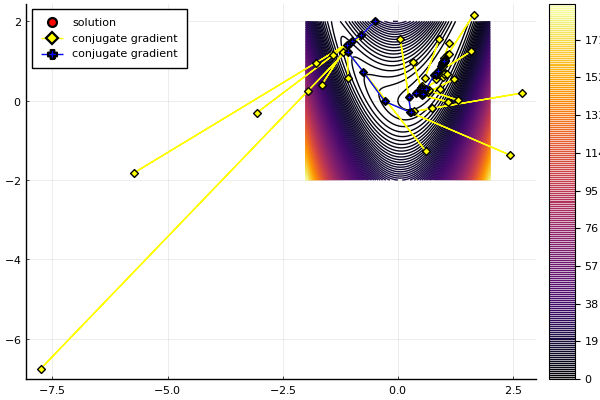

In [156]:
function conjugate_gradient_receeding_step(x0,f,df;t0=0.02, reducing_factor=.9,slope_coefficient=0.5,it_max = 10, verbose = false)
    x = x0
    
    pts = [x]
    pts_full=[x]
    vals = [f(x)]
    grads = [df(x)]
    steps = []

    stop_test = false
    it = 0 #iteration number
    calls = 0
    
    #first iteration
    g = df(x)
    d = - g       # descent direction
    t_traj = receeding_step(f,g,x,d;
            reducing_factor=reducing_factor,slope_coefficient=slope_coefficient,
            it_max = it_max, verbose = verbose, t0=t0)# step size
    calls += length(t_traj)
    t = t_traj[end]
        for t in t_traj
            push!(pts_full, x+t*d)
        end
    x += t*d          # step

    # keeping track of results
    push!(pts,x)
    push!(vals,f(x))
    push!(grads,g)
    push!(steps,t)
    
    
    while !stop_test
        beta_FR = (norm(df(x),2)/norm(g,2))^2
        beta_PR = df(x)'*(df(x)-g)/norm(g,2)^2
        g = df(x)
        
        d =  -g + beta_PR*d  ### TO COMPLETE
        t_traj = receeding_step(f,g,x,d;
            reducing_factor=reducing_factor,slope_coefficient=slope_coefficient,
            it_max = it_max, verbose = verbose, t0=t0)# step size
        calls += length(t_traj)
        t = t_traj[end]
        for t in t_traj
            push!(pts_full, x+t*d)
        end
        x += t*d          # step

        # keeping track of results
        push!(pts,x)
        push!(vals,f(x))
        push!(grads,g)
        push!(steps,t)
        
        # stopping test
        it += 1
        stop_test = (it > IT_MAX - 1) || (norm(g)<ε)
    end
    
    println("conjugate gradient algorithm with receeding step size ended in ", it, " iterations and ", calls," oracle calls")
    return pts,pts_full, vals, grads, steps
   
end

pts_cg,pts_full_cg, vals, grads,steps = conjugate_gradient_receeding_step(x0,f,df;t0=0.5, reducing_factor=0.2,slope_coefficient=0.1,it_max = 10, verbose = false);
plt = plot_trajectory(pts_full_cg,label="conjugate gradient",shape = :diamond,color = :yellow)
plt = plot_trajectory(pts_cg,label="conjugate gradient",plt=plt)

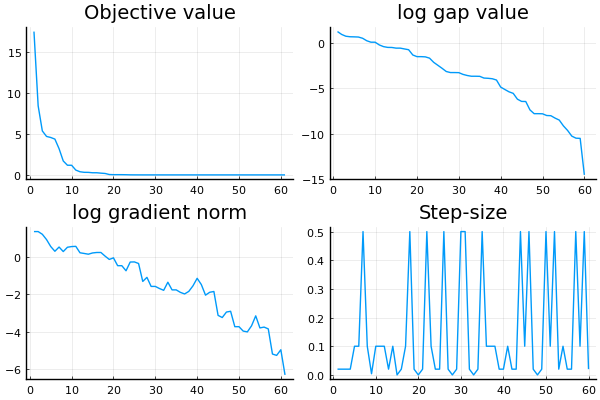

In [157]:
plot_convergence(vals,grads,steps)

In [158]:
for t in range(0.1, 1.0, length = 10)
    for alpha in range(0.1, 0.5, length = 5)
        for beta in range(0.1, 1.0, length = 10)
            println(t,alpha,beta)
            conjugate_gradient_receeding_step(x0,f,df;t0=t, reducing_factor=beta,slope_coefficient=alpha,it_max = 10, verbose = false)
        end
    end
end

0.10.10.1
conjugate gradient algorithm with receeding step size ended in 176 iterations and 283 oracle calls
0.10.10.2
conjugate gradient algorithm with receeding step size ended in 82 iterations and 149 oracle calls
0.10.10.3
conjugate gradient algorithm with receeding step size ended in 98 iterations and 308 oracle calls
0.10.10.4
conjugate gradient algorithm with receeding step size ended in 55 iterations and 114 oracle calls
0.10.10.5
conjugate gradient algorithm with receeding step size ended in 138 iterations and 430 oracle calls
0.10.10.6
conjugate gradient algorithm with receeding step size ended in 110 iterations and 411 oracle calls
0.10.10.7
conjugate gradient algorithm with receeding step size ended in 131 iterations and 791 oracle calls
0.10.10.8
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5091 oracle calls
0.10.10.9
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5045 oracle calls
0.10.11.0
conjugat

conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5051 oracle calls
0.20.51.0
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
0.30.10.1
conjugate gradient algorithm with receeding step size ended in 93 iterations and 191 oracle calls
0.30.10.2
conjugate gradient algorithm with receeding step size ended in 59 iterations and 164 oracle calls
0.30.10.3
conjugate gradient algorithm with receeding step size ended in 93 iterations and 299 oracle calls
0.30.10.4
conjugate gradient algorithm with receeding step size ended in 48 iterations and 167 oracle calls
0.30.10.5
conjugate gradient algorithm with receeding step size ended in 54 iterations and 213 oracle calls
0.30.10.6
conjugate gradient algorithm with receeding step size ended in 867 iterations and 6858 oracle calls
0.30.10.7
conjugate gradient algorithm with receeding step size ended in 161 iterations and 1317 oracle calls
0.30.10.8
conjugate gradient

conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5263 oracle calls
0.40.50.9
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
0.40.51.0
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
0.50.10.1
conjugate gradient algorithm with receeding step size ended in 854 iterations and 3221 oracle calls
0.50.10.2
conjugate gradient algorithm with receeding step size ended in 59 iterations and 178 oracle calls
0.50.10.3
conjugate gradient algorithm with receeding step size ended in 51 iterations and 181 oracle calls
0.50.10.4
conjugate gradient algorithm with receeding step size ended in 101 iterations and 583 oracle calls
0.50.10.5
conjugate gradient algorithm with receeding step size ended in 59 iterations and 403 oracle calls
0.50.10.6
conjugate gradient algorithm with receeding step size ended in 324 iterations and 2683 oracle calls
0.50.10.7
conjugate grad

conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
0.60.51.0
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5031 oracle calls
0.70.10.1
conjugate gradient algorithm with receeding step size ended in 452 iterations and 1284 oracle calls
0.70.10.2
conjugate gradient algorithm with receeding step size ended in 59 iterations and 263 oracle calls
0.70.10.3
conjugate gradient algorithm with receeding step size ended in 54 iterations and 214 oracle calls
0.70.10.4
conjugate gradient algorithm with receeding step size ended in 45 iterations and 206 oracle calls
0.70.10.5
conjugate gradient algorithm with receeding step size ended in 32 iterations and 160 oracle calls
0.70.10.6
conjugate gradient algorithm with receeding step size ended in 100 iterations and 822 oracle calls
0.70.10.7
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5080 oracle calls
0.70.10.8
conjugate gradie

conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5031 oracle calls
0.90.10.1
conjugate gradient algorithm with receeding step size ended in 179 iterations and 495 oracle calls
0.90.10.2
conjugate gradient algorithm with receeding step size ended in 68 iterations and 285 oracle calls
0.90.10.3
conjugate gradient algorithm with receeding step size ended in 60 iterations and 225 oracle calls
0.90.10.4
conjugate gradient algorithm with receeding step size ended in 65 iterations and 320 oracle calls
0.90.10.5
conjugate gradient algorithm with receeding step size ended in 56 iterations and 373 oracle calls
0.90.10.6
conjugate gradient algorithm with receeding step size ended in 53 iterations and 392 oracle calls
0.90.10.7
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5729 oracle calls
0.90.10.8
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
0.90.10.9
conjugate gradient

conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5031 oracle calls
1.00.40.1
conjugate gradient algorithm with receeding step size ended in 102 iterations and 270 oracle calls
1.00.40.2
conjugate gradient algorithm with receeding step size ended in 83 iterations and 279 oracle calls
1.00.40.3
conjugate gradient algorithm with receeding step size ended in 46 iterations and 165 oracle calls
1.00.40.4
conjugate gradient algorithm with receeding step size ended in 38 iterations and 163 oracle calls
1.00.40.5
conjugate gradient algorithm with receeding step size ended in 35 iterations and 188 oracle calls
1.00.40.6
conjugate gradient algorithm with receeding step size ended in 31 iterations and 208 oracle calls
1.00.40.7
conjugate gradient algorithm with receeding step size ended in 40 iterations and 378 oracle calls
1.00.40.8
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5041 oracle calls
1.00.40.9
conjugate gradient al

Q3: Using the FR $\beta$, the algorithm converges with $121$ oracle calls for the parameters $(t_0=0.6, \alpha=0.4, \beta=0.3)$. The PR $\beta$ algorithm does even better with only $74$ calls for the parameters $(t_0=0.1, \alpha=0.2, \beta=0.4)$. Once again, maybe by refining the mesh we could reach an even smaller number of calls.

### Newton's method

<div class="alert alert-success"> <b>Question 4)</b> 

Implement the Newton method with reducing step. 
Test-it and plot the trajectory. What do you observe ? 

Identify the problem and suggest an easy fix.
</div>


NB : I get 20 oracles calls.


NBB : Funnily enough, on this particular example, doing things poorly yield the solution quicker, in 7 calls. Do not generalize this result...

Newton algorithm ended in 11 iterations and 37 calls


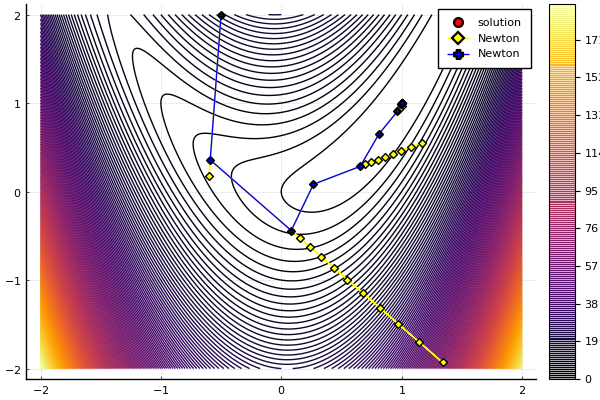

In [180]:
x0 = Float64[-0.5, 2]

function Newton(x0,f,df, hf;reducing_factor=.9,slope_coefficient=0.5,it_max = 10, verbose = false)
    x = x0
    t0 = 1.1
    
    pts = [x]
    pts_full = [x]
    vals = [f(x)]
    grads = [df(x)]
    steps=[]
    
    
    stop_test = false
    it = 0 #iteration number
    calls = 0
    
    while !stop_test
        
        g = df(x)         # gradient
        H = hf(x)         # hessian
        
        ## TO COMPLETE
        d =  -inv(H)*g# descent direction 
       
        
        t_traj = receeding_step(f,g,x,d;
            reducing_factor=reducing_factor,slope_coefficient=slope_coefficient,
            it_max = it_max, verbose = verbose, t0=t0)# step size
        calls += length(t_traj)
        t = t_traj[end]
        for t in t_traj
            push!(pts_full, x+t*d)
        end
        x += t*d          # step

        # keeping track of results
        push!(pts,x)
        push!(vals,f(x))
        push!(grads,g)
        push!(steps,t)
        
        # stopping test
        it += 1
        stop_test = (it > IT_MAX - 1) || (norm(g)<ε)
    end
    
    println("Newton algorithm ended in ", it, " iterations and ", calls, " calls")
    return pts, pts_full, vals, grads, steps
   
end

pts_n,pts_n_full, vals,grads,steps = Newton(x0,f,df, hf; reducing_factor = 0.9, slope_coefficient=0.5)


plt = plot_trajectory(pts_n_full,label="Newton",shape = :diamond,color = :yellow)
plt = plot_trajectory(pts_n,label="Newton",plt=plt)

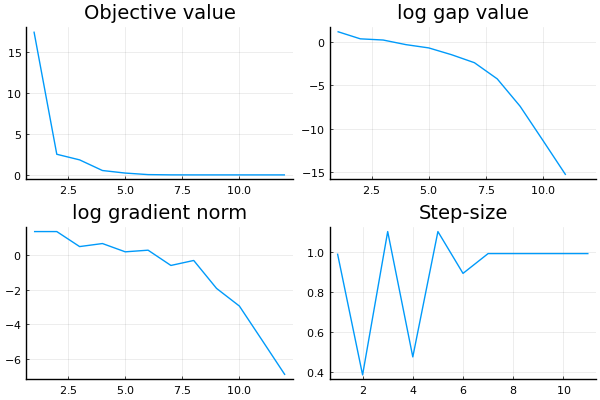

In [181]:
plot_convergence(vals,grads,steps)

In [179]:
for alpha in range(0.1, 0.5, length = 5)
    for beta in range(0.1, 1.0, length = 10)
        println(alpha,beta)
        Newton(x0,f,df, hf; reducing_factor = beta, slope_coefficient=alpha)
    end
end

0.10.1
Newton algorithm ended in 17 iterations and 26 calls
0.10.2
Newton algorithm ended in 10 iterations and 11 calls
0.10.3
Newton algorithm ended in 11 iterations and 12 calls
0.10.4
Newton algorithm ended in 10 iterations and 11 calls
0.10.5
Newton algorithm ended in 11 iterations and 13 calls
0.10.6
Newton algorithm ended in 10 iterations and 12 calls
0.10.7
Newton algorithm ended in 10 iterations and 13 calls
0.10.8
Newton algorithm ended in 10 iterations and 14 calls
0.10.9
Newton algorithm ended in 10 iterations and 19 calls
0.11.0
Newton algorithm ended in 7 iterations and 17 calls
0.20.1
Newton algorithm ended in 19 iterations and 30 calls
0.20.2
Newton algorithm ended in 11 iterations and 13 calls
0.20.3
Newton algorithm ended in 11 iterations and 12 calls
0.20.4
Newton algorithm ended in 10 iterations and 11 calls
0.20.5
Newton algorithm ended in 10 iterations and 12 calls
0.20.6
Newton algorithm ended in 10 iterations and 12 calls
0.20.7
Newton algorithm ended in 10 itera

Q4: Looking at the plot made with the parameters of the subject, we notice that for some reasons that the convergence path makes a wide curve before reaching the optimal point. In consequence, the algorithm needs some more iterations to converge. An easy fix is to increase slightly the initial step size $t_0$ as to avoid falling in false well of minimization. As mentionned, doing this will actualy deteriorate the number of iteration in this particular case (with the parameters of the subject, and taking $t_0=1.1$ instead of $1.0$ we go from $32$ calls to $37$ calls. Thus we didn't keep this change.

With the Newton algorithm we easily reach $11$ oracle calls, for example with the parameters $(\alpha = 0.1, \beta=0.2)$. As before, refining the mesh of parameters shall help find an even better solution (certainly $7$ as mentionned).

For what follows, as in the end we will change the function studied, we went back to the change $t_0=1.1$.

### Quasi-Newton Method 

<div class="alert alert-success"> <b>Question 5)</b> 
Implement now the BFGS method.
</div>

NB : I got the 24 oracle calls

BFGS algorithm ended in 14 iterations and 18 calls


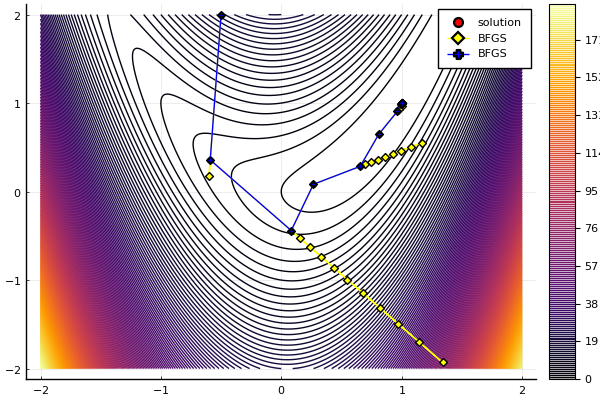

In [220]:
function BFGS(x0,f,df;reducing_factor=.7,slope_coefficient=0.5,it_max = 10, verbose = false)
    x = x0
    
    pts = [x]
    pts_full = [x]
    vals = [f(x)]
    grads = [df(x)]
    steps = []
    
    stop_test = false
    it = 0 #iteration number
    calls = 0
    
    g_old = df(x)
    x_old = x0
    
    W = I
    
    while !stop_test
        g = df(x)         # gradient
            
        ## Computing W
        if it > 0
            delta_g = g - g_old
            delta_x = x - x_old
            g_old = g
            x_old = x
            W = (I - delta_x*delta_g'/(delta_g'*delta_x))*W*(I - delta_g*delta_x'/(delta_g'*delta_x)) + delta_x*delta_x'/(delta_g'*delta_x)
        end
        
        ## TO COMPLETE 
        d = - W*g       # descent direction 
        #print(W)
        
        if g'*d >= 0 # checking for non-decreasing step
            println("non-decreasing direction at it ", it,", using gradient step instead")
            d = - g
        end
        t_traj = receeding_step(f,g,x,d;
            reducing_factor=reducing_factor,slope_coefficient=slope_coefficient,
            it_max = it_max, verbose = verbose, t0=1.0)# step size
        calls += length(t_traj)
        t = t_traj[end]
        for t in t_traj
            push!(pts_full, x+t*d)
        end
        x += t*d          # step
        
        # keeping track of results
        push!(pts,x)
        push!(vals,f(x))
        push!(grads,g)
        push!(steps,t)
        
        # stopping test
        it += 1
        stop_test = (it > IT_MAX - 1) || (norm(g)<ε)
    end
    
    println("BFGS algorithm ended in ", it, " iterations and ", calls, " calls")
    return pts,pts_full, vals, grads, steps
   
end

pts_bfgs,pts_bfgs_full, vals,grads, steps = BFGS(x0,f,df; reducing_factor = 0.2, slope_coefficient=0.1, it_max = 20)

plt = plot_trajectory(pts_n_full,label="BFGS",shape = :diamond,color = :yellow)
plt = plot_trajectory(pts_n,label="BFGS",plt=plt)

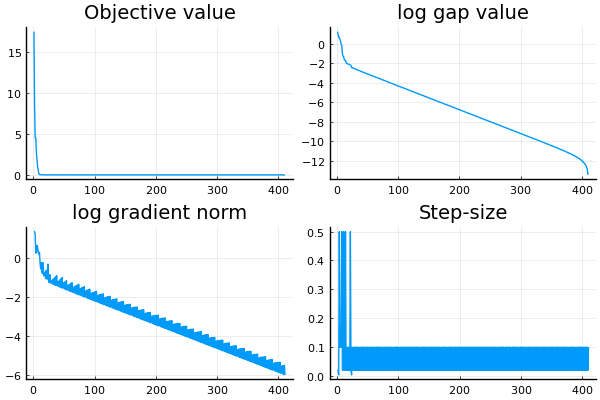

In [56]:
plot_convergence(vals,grads,steps)

### Plotting multiple trajectories

To compare the algorithm we can plot multiple trajectories on the same graph.

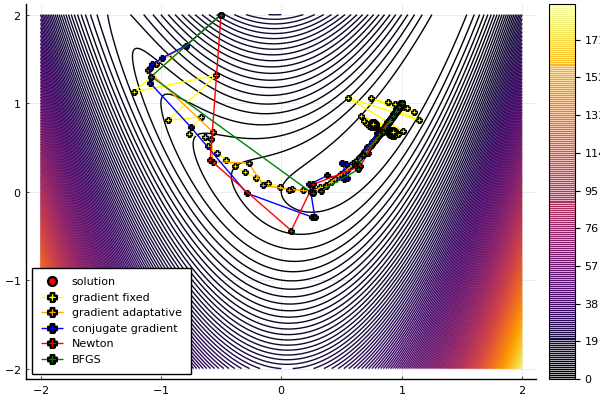

In [222]:
plt=plot_trajectory(pts_gf,label="gradient fixed",color="yellow")
plt=plot_trajectory(pts_gr,label="gradient adaptative",color="orange",plt=plt)
plt=plot_trajectory(pts_cg,label="conjugate gradient",color="blue",plt=plt)
plt=plot_trajectory(pts_n,label="Newton",color="red",plt=plt)
plt=plot_trajectory(pts_bfgs,label="BFGS",color="green",plt=plt)

## Quadratic function and conditionning

We are now going to test the effect of the condition number on the algorithm


<div class="alert alert-success"> <b>Question 6)</b> 

Test the algorithms on quadratic function. 
Comment on the dependence in the dimension and conditionning.
</div>


In [223]:
n = 500        # dimension
κ = 100        # condition number

# generating a random symetric matrix of condition κ
X = rand(n,n) 
Q = X'X
U,S,V = svd(Q) 
γ = (κ-1)/(S[1]-S[end] ) # scaling factor
S = [(S[i]-S[end])*γ + 1 for i in 1:n]
Q = U*diagm(S)*V'

# defining the oracle
f_Q(x) = 0.5*x'*Q*x
df_Q(x) = Q*x
hf_Q(x) = Q

# Initial point
x0 = ones(n); # the optimal solution is obviously 0, so the initial point should be something else


In [224]:
t0 = 0.5
gradient_fixed_step(x0,f_Q,df_Q;t0=t0);
gradient_receeding_step(x0,f_Q,df_Q;t0=t0);
conjugate_gradient_receeding_step(x0,f_Q,df_Q;t0=t0);
Newton(x0,f_Q,df_Q,hf_Q);
BFGS(x0,f_Q,df_Q);

gradient algorithm with fixed step t=0.5 ended in 5000 iterations and 5000 oracle call
gradient algorithm with receeding step size ended in 5000 iterations and 6250 oracle calls
conjugate gradient algorithm with receeding step size ended in 5000 iterations and 5071 oracle calls
Newton algorithm ended in 6 iterations and 12 calls
BFGS algorithm ended in 21 iterations and 51 calls


Clearly, the Newton methods are wayy better to deal with more complicated functions as the others didn't even converge in less than $5000$ iterations. Yet, we see that choosing wisely the parameters help greatly to get result in no time as in this case the Newton algo converges faster and with less oracle calls than the quasi-newton algorithm.

<div class="alert alert-warning"> <b>Question 7) [Optional]</b> 
In class we said that the conjugate gradient algorithm should converge in at most $n$ iterations. Do we observe this here ? Why ? 

Write a conjugate gradient method that would satisfy this convergence.
</div>

<div class="alert alert-warning"> <b>Question 8) [Optional]</b> 

Write a conjugate gradient method for solving a random linear system $Ax=b$. 

Test it with random matrices.
</div>

## Non-convex function in higher dimension

We will now test our algorithms on the Rosenbrock function in higher dimension.

$$ f_\kappa(x) = \sum_{i=1}^{n-1} \kappa (x_{i+1} - x_i^2)^2 + (x_i -1)^2 $$

for $\kappa \geq 0$.

<div class="alert alert-warning"> <b>Question 9) [Optional]</b> 

Find, for any $\kappa \geq 0$ the global minimum of $f_\kappa$. Is it unique ?

Compute the gradient and the hessian of $f_{\kappa}$.
</div>

<div class="alert alert-warning"> <b>Question 10) [Optional]</b> 

Test the algorithms for various dimensions, starting points and $\kappa$.
Comment your numerical observations.

NB : The standard Rosenbrock function use $\kappa = 100$ and is known to be difficult to solve. 
</div>